# AMIA Trabajo Práctico final CEIA 17Co2024
## Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm

In [1]:
import numpy as np
from utils import ClassEncoder
from datasets import get_iris_dataset
X_full_iris, y_full_iris = get_iris_dataset()
print(X_full_iris.shape)
print(y_full_iris.shape)

(150, 4)
(150, 1)


In [2]:
def print_distribution(_y):
    encoder = ClassEncoder()
    encoded_y = encoder.fit_transform(_y) # convert class to number (encode)
    print('Distribución de clases:')
    distribution = np.bincount(encoded_y.flatten())/len(encoded_y)
    for class_name, value in zip(encoder.names, distribution):
        print(f'{class_name}: {value:.4f}')

print_distribution(y_full_iris)


Distribución de clases:
setosa: 0.3333
versicolor: 0.3333
virginica: 0.3333


Se observa que el dataset Iris se encuentra balanceado, es decir que no hay alguna preponderancia de alguna de las clases por sobre las demás.

### 1) QDA Entrenado con:  probabilidades a priori uniforme y  una clase con probabilidad 0.9, las demás 0.05 ( 3 combinaciones)

In [3]:
from utils import split_transpose, QDA, accuracy

def priori_test(dataset):
    X_full, y_full = dataset
    a_priori_A = [1/3, 1/3, 1/3] # modelo 0
    a_priori_B_1 = [0.9, 0.05, 0.05] # modelo 1
    a_priori_B_2 = [0.05, 0.9, 0.05] # modelo 2
    a_priori_B_3 = [0.05, 0.05, 0.9] # modelo 3
    
    a_priori_list = [a_priori_A, a_priori_B_1, a_priori_B_2, a_priori_B_3]
    # from utils import QDA
    # rng_seed = 6543
    train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 6543)
    
    for i,_a_priori in enumerate(a_priori_list):
        model = QDA()
        model.fit(train_x, train_y, _a_priori)
        print('A prioris:')
        print(",".join([f' {class_name}:{p:.3f} ' for class_name, p in zip(model.encoder.names, _a_priori)]))
        train_acc = accuracy(train_y, model.predict(train_x))
        test_acc = accuracy(test_y, model.predict(test_x))
        print(f"[Model {i}] Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")
        # print('\n')

priori_test(get_iris_dataset())

A prioris:
 setosa:0.333 , versicolor:0.333 , virginica:0.333 
[Model 0] Train (apparent) error is 0.0222 while test error is 0.0167
A prioris:
 setosa:0.900 , versicolor:0.050 , virginica:0.050 
[Model 1] Train (apparent) error is 0.0222 while test error is 0.0167
A prioris:
 setosa:0.050 , versicolor:0.900 , virginica:0.050 
[Model 2] Train (apparent) error is 0.0333 while test error is 0.0000
A prioris:
 setosa:0.050 , versicolor:0.050 , virginica:0.900 
[Model 3] Train (apparent) error is 0.0333 while test error is 0.0500


A partir de estos datos y dejando de lado cuál es la verdadera distribución, se podrían hacer las siguientes suposiciones:
- El modelo 0 y el modelo 1 parecerían cometer el mismo grado de error al hacer dichas suposiciones sobre los priors (la clase setosa no parece verse afectada).
- El modelo 2 parecería sobreajustar (hay overfitting) a los datos de test.
- El modelo 3 tiene un mayor error tanto en el entrenamiento como en la prueba, lo que indica que no logra generalizar y que dichos priors tienen un efecto detrimental en la performance del modelo.
- Vemos que en los casos 2 y 3 aumenta el error en train y esto podria tener que ver con que la priori de setosa es baja.

Se utilizará la versión de QDA provista por SKLearn (a pesar de las diferencias en su implementación) a modo de evaluar cualitativamente el efecto de los priors sobre éste dataset y confirmar las suposiciones ya mencionadas, utilizando Cross Validation:

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

def priori_test_cross_val(dataset):
    X_full, y_full = dataset
    a_priori_A = [1/3, 1/3, 1/3] # modelo 0
    a_priori_B_1 = [0.9, 0.05, 0.05] # modelo 1
    a_priori_B_2 = [0.05, 0.9, 0.05] # modelo 2
    a_priori_B_3 = [0.05, 0.05, 0.9] # modelo 3
        
    a_priori_list = [a_priori_A, a_priori_B_1, a_priori_B_2, a_priori_B_3]
    
    for i, _priors in enumerate(a_priori_list):
        qda = QuadraticDiscriminantAnalysis(priors=_priors) #utilizo QDA de sklearn para poder utilizar cross_val_score sin problemas
        cv_scores = cross_val_score(qda, X_full, y_full.flatten(), cv=5)  # 5-fold cross-validation
        print(f"Accuracy with priors {_priors}: {cv_scores.mean()} ± {cv_scores.std()} for model {i}")

priori_test_cross_val(get_iris_dataset())

Accuracy with priors [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]: 0.9800000000000001 ± 0.02666666666666666 for model 0
Accuracy with priors [0.9, 0.05, 0.05]: 0.9800000000000001 ± 0.02666666666666666 for model 1
Accuracy with priors [0.05, 0.9, 0.05]: 0.9733333333333334 ± 0.024944382578492935 for model 2
Accuracy with priors [0.05, 0.05, 0.9]: 0.9666666666666668 ± 0.036514837167011066 for model 3


Aquí se ve que el resultado del modelo 2 anterior no era representativo. La precisión es ligeramente menor que en los modelos anteriores, lo que podría indicar que las muestras de la segunda clase no son tan fácilmente separables como las de la primera clase.

En cuanto al modelo 3: presenta la precisión más baja y la desviación estándar más alta, lo que podría sugerir que la tercera clase es la más difícil de clasificar correctamente o que el sesgo hacia esa clase introduce más incertidumbre en las predicciones.

Con respecto al modelo 0 y 1: cabe la posibilidad de pensar que por ejemplo, las características que definen la primera clase son muy distintas, el modelo podría seguir clasificando correctamente la mayoría de las instancias de esa clase, incluso si los priors cambian. Ello querría decir que dicha clase es fácilmente separable de las demás. Para obtener una visión más clara de qué sucediendo entre el modelo 1 y el 0, se puede ver la matriz de confusión.

In [5]:
from sklearn.metrics import confusion_matrix

def get_cm(model, test_x, test_y):
    test_preds_0 = model.predict(test_x)
    return confusion_matrix(test_y.T, test_preds_0.T)


X_full, y_full = get_iris_dataset()
a_priori_A = [1/3, 1/3, 1/3] # modelo 0
a_priori_B_1 = [0.9, 0.05, 0.05] # modelo 1
a_priori_B_2 = [0.05, 0.9, 0.05] # modelo 2
a_priori_B_3 = [0.05, 0.05, 0.9] # modelo 3

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 6543)

model = QDA()

model.fit(train_x, train_y, a_priori_A)
print("Matriz de confusión de prueba para el modelo 0:")
print(get_cm(model, test_x, test_y))

model.fit(train_x, train_y, a_priori_B_1)
print("Matriz de confusión de prueba para el modelo 1:")
print(get_cm(model, test_x, test_y))

Matriz de confusión de prueba para el modelo 0:
[[23  0  0]
 [ 0 20  1]
 [ 0  0 16]]
Matriz de confusión de prueba para el modelo 1:
[[23  0  0]
 [ 0 20  1]
 [ 0  0 16]]


El hecho de que el modelo 1, con priors sesgados ([0.9, 0.05, 0.05]), produzca una matriz de confusión similar indica que la información proporcionada por los datos (en este caso de la clase 1) es lo suficientemente fuerte como para compensar el sesgo de los priors.


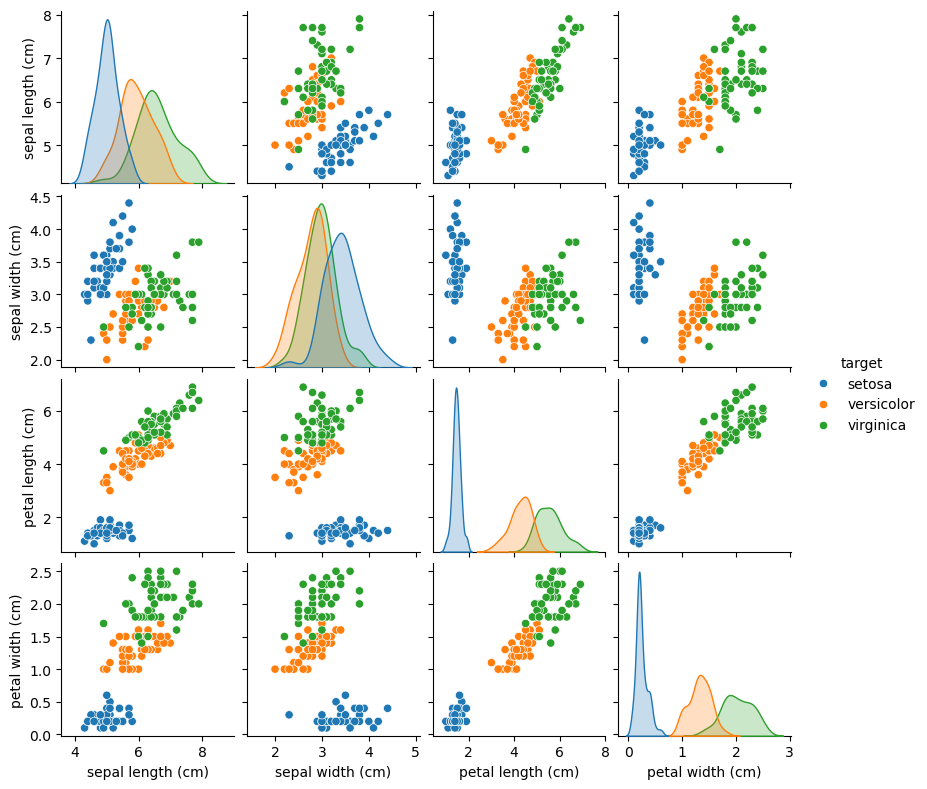

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris(as_frame=True)
df = iris.frame
df['target'] = df['target'].map(dict(enumerate(iris.target_names)))
sns.pairplot(df, hue='target', height=2)
plt.show()

Aquí se verifica efectivamente que la clase 0 (setosa) es linealmente (y fácilmente) separable de las demás.

## 2) Repetir punto 1 para el dataset penguin

In [7]:
from datasets import get_penguins
X_full_penguin, y_full_penguin = get_penguins()
print(X_full_penguin.shape)
print_distribution(y_full_penguin)

(342, 4)
Distribución de clases:
Adelie: 0.4415
Chinstrap: 0.1988
Gentoo: 0.3596


Se puede observar este dataset no está balanceado con respecto a la cantidad de datos por clase.

In [8]:
priori_test(get_penguins())

A prioris:
 Adelie:0.333 , Chinstrap:0.333 , Gentoo:0.333 
[Model 0] Train (apparent) error is 0.0098 while test error is 0.0073
A prioris:
 Adelie:0.900 , Chinstrap:0.050 , Gentoo:0.050 
[Model 1] Train (apparent) error is 0.0195 while test error is 0.0219
A prioris:
 Adelie:0.050 , Chinstrap:0.900 , Gentoo:0.050 
[Model 2] Train (apparent) error is 0.0098 while test error is 0.0219
A prioris:
 Adelie:0.050 , Chinstrap:0.050 , Gentoo:0.900 
[Model 3] Train (apparent) error is 0.0098 while test error is 0.0073


Los modelos que mejor generalizan son el 0 y el 3. Parece ser un caso análogo al de Iris en cuanto a lo que sucede con diferentes priors. Se intentará verificar a continuación si esto es así:

In [9]:
priori_test_cross_val(get_penguins())

Accuracy with priors [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]: 0.9882779198635976 ± 0.010993807100854342 for model 0
Accuracy with priors [0.9, 0.05, 0.05]: 0.9824381926683717 ± 0.005925745287640952 for model 1
Accuracy with priors [0.05, 0.9, 0.05]: 0.9589514066496164 ± 0.025287380244108995 for model 2
Accuracy with priors [0.05, 0.05, 0.9]: 0.9882779198635976 ± 0.010993807100854342 for model 3


Se puede ahora notar nuevamente que los modelos 1 (aunque por muy poco) y 2 son los que peor performan.

In [10]:
X_full, y_full = get_penguins()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 6543)

model = QDA()

model.fit(train_x, train_y, a_priori_A)
print("Matriz de confusión de prueba para el modelo 0:")
print(get_cm(model, test_x, test_y))

model.fit(train_x, train_y, a_priori_B_1)
print("Matriz de confusión de prueba para el modelo 1:")
print(get_cm(model, test_x, test_y))

model.fit(train_x, train_y, a_priori_B_2)
print("Matriz de confusión de prueba para el modelo 2:")
print(get_cm(model, test_x, test_y))

model.fit(train_x, train_y, a_priori_B_3)
print("Matriz de confusión de prueba para el modelo 3:")
print(get_cm(model, test_x, test_y))

Matriz de confusión de prueba para el modelo 0:
[[67  0  0]
 [ 1 28  0]
 [ 0  0 41]]
Matriz de confusión de prueba para el modelo 1:
[[67  0  0]
 [ 3 26  0]
 [ 0  0 41]]
Matriz de confusión de prueba para el modelo 2:
[[64  3  0]
 [ 0 29  0]
 [ 0  0 41]]
Matriz de confusión de prueba para el modelo 3:
[[67  0  0]
 [ 1 28  0]
 [ 0  0 41]]


De aquí se puede concluir que existe una relación de compromiso entre clasificar correctamente las muestras de la primera y segunda clase. El límite de decisión que genera un error 0 requiera probablemente de mayor complejidad (trayendo aparejado un posible problema de overfitting) o siendo imposible de lograr.

El modelo 0 cuyos priors son los que más se asemejan a los reales, es uno de los que mejor performa. El modelo 3 da resultados similares; ello se debe a que la tercera clase tiene menor superposición con las demás (puesto a que todos los modelos, a pesar de la abismal diferencia entre priors, han sido capaz de clasificarlos correctamente) y por lo tanto, la información proporcionada por los datos es lo suficientemente fuerte como para compensar el sesgo del prior (análogo al dataset anterior). Se verifica lo mencionado a continuación:

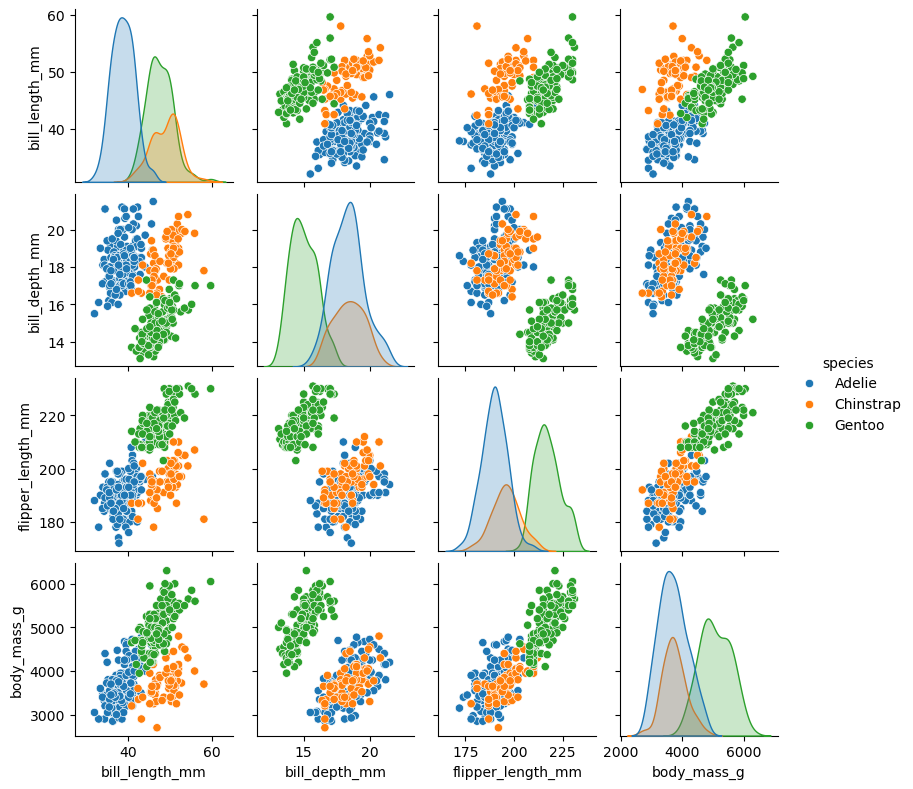

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = sns.load_dataset("penguins")
sns.pairplot(df, hue='species', height=2)
plt.show()

### 3) Implementar LDA

In [12]:
from utils import BaseBayesianClassifier, inv, det

class LDA(BaseBayesianClassifier):
    # Utiliza una matriz de covarianza ponderada para evitar que clases con mayor cantidad de muestras tengan mayor influencia en su valor final. 
    # Al ponderar, se intenta que la variabilidad dentro de la clase más pequeña también sea tenida en cuenta de manera proporcional.

  def _fit_params(self, X, y):
    # Inicializa la matriz de covarianza ponderada
    
    cov_matrix = np.zeros((X.shape[0], X.shape[0]))
    
    # Suma la covarianza de cada clase ponderada por su tamaño
    for idx in range(len(self.log_a_priori)):
        X_class = X[:, y.flatten() == idx]
        cov_matrix += np.cov(X_class, bias=True) * X_class.shape[1] # estimador de máxima verosimilitud
        # cov_matrix += np.cov(X_class, bias=False) * (X_class.shape[1] - 1) # estimador insesgado

    # Divide por el número total de muestras
    cov_matrix /= X.shape[1] # estimador de máxima verosimilitud
      
    # # Divide por el número total de muestras (menos 1 para corrección de Bessel)
    # cov_matrix /= (X.shape[1] - len(self.log_a_priori)) # estimador insesgado
    
    # Calcula la inversa de la matriz de covarianza ponderada
    self.inv_cov = inv(cov_matrix)
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True) for idx in range(len(self.log_a_priori))]


  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(self.inv_cov)) -0.5 * unbiased_x.T @ self.inv_cov @ unbiased_x

Se comparar LDA vs QDA (Sin multiples prioris, es decir que se estimen a partir de los datos) con los dos datasets:

In [13]:
for dataset_name, dataset in zip(['iris', 'penguins'], [get_iris_dataset(), get_penguins()]):
    for model_name, curr_model in zip(['QDA', 'LDA'], [QDA, LDA]):
        model = curr_model()
        x_full, y_full = dataset
        train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, 0.4, 6543)
        model.fit(train_x, train_y)
        train_acc = accuracy(train_y, model.predict(train_x))
        test_acc = accuracy(test_y, model.predict(test_x))
        print(f"[Dataset={dataset_name}][Model={model_name}] train err {1-train_acc:.4f}, test err {1-test_acc:.4f}")

[Dataset=iris][Model=QDA] train err 0.0111, test err 0.0167
[Dataset=iris][Model=LDA] train err 0.0222, test err 0.0167
[Dataset=penguins][Model=QDA] train err 0.0146, test err 0.0146
[Dataset=penguins][Model=LDA] train err 0.0098, test err 0.0146


Para estos datasets, parecería no haber diferencias significativas entre QDA y LDA. Se procederá a verificar esto en el siguiente punto.



### 4) Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?

In [14]:
import pandas as pd
df = pd.DataFrame()

for dataset_name,dataset in zip(['iris', 'penguins'],[get_iris_dataset(), get_penguins()]):
    for model_name, curr_model in zip(['QDA', 'LDA'],[QDA, LDA]):
        for seed in [6543, 5501,125]:
            model = curr_model()
            x_full, y_full = dataset
            train_x, train_y, test_x, test_y = split_transpose(x_full, y_full,test_sz=0.4, random_state=seed)
            model.fit(train_x, train_y)
            train_acc = accuracy(train_y, model.predict(train_x))
            test_acc = accuracy(test_y, model.predict(test_x))
            # print(f"[Dataset={dataset_name}][Model={model_name}] train err {1-train_acc:.4f}, test err {1-test_acc:.4f}")
            row = {
                'Dataset': dataset_name,
                'Model': model_name,
                'seed': seed,
                'Error (train)': 1-train_acc,
                'Error (test)': 1-test_acc,
            }
            
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
print(df)
    

     Dataset Model  seed  Error (train)  Error (test)
0       iris   QDA  6543       0.011111      0.016667
1       iris   QDA  5501       0.022222      0.016667
2       iris   QDA   125       0.022222      0.016667
3       iris   LDA  6543       0.022222      0.016667
4       iris   LDA  5501       0.022222      0.016667
5       iris   LDA   125       0.011111      0.016667
6   penguins   QDA  6543       0.014634      0.014599
7   penguins   QDA  5501       0.014634      0.007299
8   penguins   QDA   125       0.009756      0.014599
9   penguins   LDA  6543       0.009756      0.014599
10  penguins   LDA  5501       0.009756      0.014599
11  penguins   LDA   125       0.014634      0.007299


### Conclusion

LDA tiende a ser más adecuado cuando se dispone de una cantidad limitada de datos, mientras que QDA muestra su verdadero potencial en escenarios con un mayor volumen de datos y una mayor variabilidad entre clases. Esto se debe a que LDA asume una matriz de covarianza común para todas las clases, lo que lo hace más robusto en situaciones con menos datos o clases desbalanceadas.

En este caso, la igualdad en los errores entre LDA y QDA puede explicarse por el dataset utilizado: baja complejidad, distribuciones de clases similares, y un tamaño de muestra que no es lo suficientemente grande para que QDA aproveche sus capacidades adicionales. Por lo tanto, la ventaja de QDA sobre LDA no se manifiesta, haciendo que LDA tenga el mismo rendimiento.

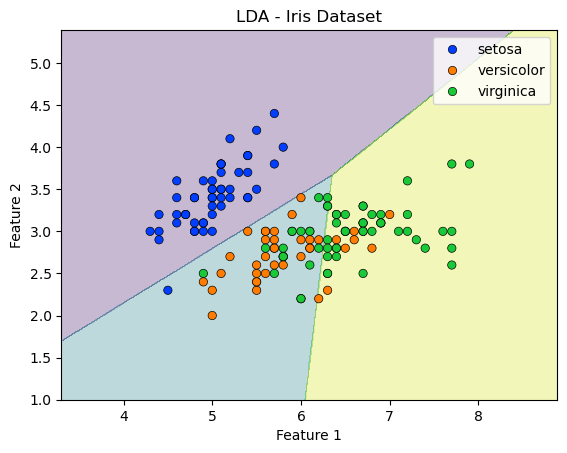

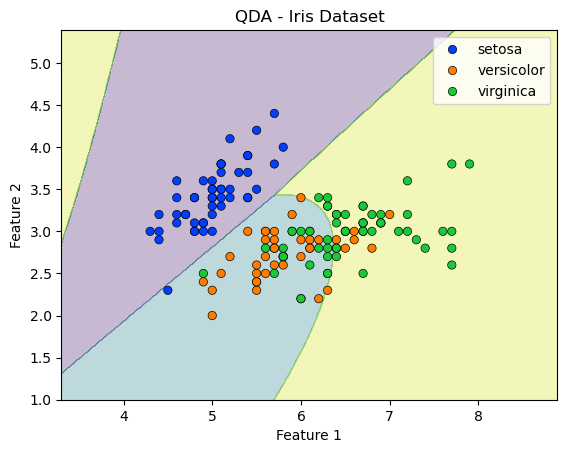

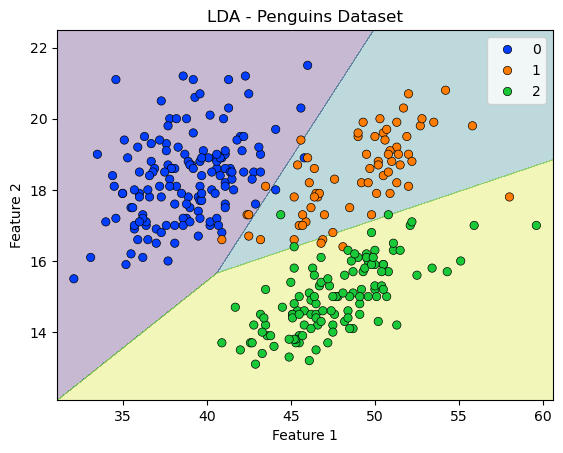

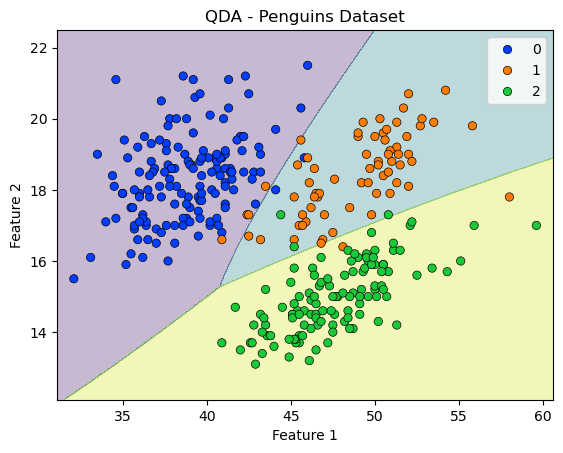

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder

def plot_decision_boundaries(X, y, model, title):
    # Crear una malla de puntos para graficar
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    
    # Predecir para cada punto en la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Asegura que Z es numérico
    if isinstance(Z[0], str):
        Z = LabelEncoder().fit_transform(Z)

    Z = Z.reshape(xx.shape)
    
    # Graficar los límites de decisión y los puntos
    plt.contourf(xx, yy, Z, alpha=0.3)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


iris = load_iris(as_frame=True)
df_iris = iris.frame

df_iris['Species'] = df_iris['target'].map(dict(enumerate(iris.target_names)))

# Seleccionar las primeras dos características y la columna target
X_iris = df_iris.iloc[:, :2].values  # Usar solo las dos primeras características
y_iris = df_iris['Species'].values

# Ahora el dataset Penguins
df_penguins = sns.load_dataset("penguins").dropna()

X_penguins = df_penguins[['bill_length_mm', 'bill_depth_mm']].values
y_penguins = df_penguins['species'].values

# Codificar las etiquetas para los pingüinos
label_encoder = LabelEncoder()
y_penguins_encoded = label_encoder.fit_transform(y_penguins)

# Inicializar los modelos
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

# Entrenar y graficar límites de decisión para Iris con LDA
lda.fit(X_iris, y_iris)
plot_decision_boundaries(X_iris, y_iris, lda, "LDA - Iris Dataset")

# Entrenar y graficar límites de decisión para Iris con QDA
qda.fit(X_iris, y_iris)
plot_decision_boundaries(X_iris, y_iris, qda, "QDA - Iris Dataset")

# Entrenar y graficar límites de decisión para Penguins con LDA
lda.fit(X_penguins, y_penguins_encoded)
plot_decision_boundaries(X_penguins, y_penguins_encoded, lda, "LDA - Penguins Dataset")

# Entrenar y graficar límites de decisión para Penguins con QDA
qda.fit(X_penguins, y_penguins_encoded)
plot_decision_boundaries(X_penguins, y_penguins_encoded, qda, "QDA - Penguins Dataset")


Se puede verificar que, para cualquier par de características, LDA traza límites de decisión lineales (que en estos gráficos 2D son rectas, pero que en dimensiones superiores resultan hiperplanos) y QDA curvas de complejidad cuadrática.

### 5) Tensorized QDA vs QDA

In [16]:
from utils import TensorizedQDA

x_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(x_full, y_full,test_sz=0.4, random_state=6543)

tqda = TensorizedQDA()
tqda.fit(train_x, train_y)
train_acc = accuracy(train_y, tqda.predict(train_x))
test_acc = accuracy(test_y, tqda.predict(test_x))

print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


In [17]:
%%timeit

tqda.predict(test_x)

826 μs ± 7.14 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
tqda_predictions = tqda.predict(test_x)

In [19]:
qda = QDA()
qda.fit(train_x, train_y)
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


In [20]:
%%timeit

qda.predict(test_x)

2.28 ms ± 14.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Tensorized QDA aprovecha que varias de las operaciones que se tienen que realizar se pueden escribir de forma matricial, pudiendo realizarse de forma paralela. Esto se hace evidente en las siguientes líneas:

```
self.tensor_inv_cov = np.stack(self.inv_covs)
self.tensor_means = np.stack(self.means)
```

Lo cual muestra que las cuentas serán hechas simultáneamente, de forma paralela, para todas las clases y luego se verifica en la firma de la función:
```
_predict_log_conditionals(self, x)
```

Ya que no es necesario especificar para qué clase será hecha dicha predicción.

## 1. Faster QDA

Si intentamos calcular todas las predicciones simultáneamente, terminamos calculando una matriz que contiene no solo la información de interés en la diagonal (auto-interacciones), sino también las interacciones cruzadas entre las observaciones.

La diagonal de esta matriz representa los términos que se usarían en el cálculo individual de la función discriminante para cada observación.
Los términos fuera de la diagonal representan interacciones entre diferentes observaciones, lo cual no es necesario si se quiere predecir para cada observación de forma independiente.
Por lo tanto, para obtener las predicciones, podrías ignorar los términos fuera de la diagonal, pero la construcción de toda la matriz sigue siendo costosa en términos de tiempo y memoria.

In [21]:
from utils import TensorizedQDA
class FasterQDAOptim1(TensorizedQDA):
    
    def _predict_log_conditionals(self, x):
        # k: clases
        # p: features
        # n: observaciones
        # x era de p x n
        # despues de hacer fit -> x es un tensor de k x p x n (o sea mismo array, k veces)
        # (se hace la prediccion para las k clases en conjunto)
        
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov @ unbiased_x
        # PUNTO 3: print(inner_prod.shape) # matrices cuadradas que pide mostrar la consigna
        
        # inner prod shape: (k, n, n) -> k matrices de n x n
        # se debe de pensar que como es un producto de tensores => cada producto produce una matriz de n x n
        
        # dado un k fijo (estando posicionados en una clase)
        # se puede imaginar que en cada matriz
        # obtengo diagonal,
        # ya que solo las que son consigo mismas son las que nos interesan (producto interno)
        new_mat = np.array([np.diag(mat) for mat in inner_prod]) # (k, n)
        # new_mat = np.sum(unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov, axis=2)
        # new_mat = np.sum(self.tensor_inv_cov@unbiased_x, axis=1)
        itcov = np.log(det(self.tensor_inv_cov)) # (k,)
        
        # truco para no tener que crear un nuevo vector itcov de (k, n) para poder sumarlo
        return 0.5 * itcov - 0.5 * new_mat.transpose() # (n, k)
        
    def predict(self, x):        
        log_cond = self._predict_log_conditionals(x) # (n, k)
        log_priors = self.log_a_priori #(k,)
        y_hat = self.encoder.names[np.argmax(log_priors + log_cond, axis=1)]
        
        return y_hat
    
fqda1 = FasterQDAOptim1()
fqda1.fit(train_x, train_y)
# fqda1.predict(train_x)

In [22]:
%%timeit
fqda1.predict(train_x)

43.5 μs ± 380 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
fqda1_predictions = fqda1.predict(test_x)
print(fqda1_predictions)

['versicolor' 'versicolor' 'virginica' 'setosa' 'virginica' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'setosa' 'versicolor' 'setosa' 'setosa'
 'versicolor' 'setosa' 'versicolor' 'setosa' 'virginica' 'setosa'
 'virginica' 'setosa' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'versicolor' 'setosa' 'versicolor' 'virginica' 'virginica' 'versicolor'
 'virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'virginica'
 'setosa' 'setosa' 'versicolor' 'virginica' 'virginica' 'setosa' 'setosa'
 'setosa' 'virginica' 'virginica' 'versicolor' 'setosa' 'virginica'
 'setosa' 'versicolor' 'setosa' 'setosa' 'setosa']


## 2. Tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.

QDA: 2.24 ms ± 19.8 μs per loop

TQDA: 822 μs ± 6.1 μs per loop

FQDA: 42.9 μs ± 62.5 ns per loop

Se puede observar como cada optimización mejoró los tiempos de predicción.

### 4. (Desarrollado hacia el final del documento).

## 5. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente.

In [24]:
from utils import TensorizedQDA
class FasterQDAOptim2(TensorizedQDA):
    
    def _predict_log_conditionals(self, x):
        unbiased_x = x - self.tensor_means
        Z = (unbiased_x.transpose(0, 2, 1) @ self.tensor_inv_cov)
        new_mat = np.sum(Z.transpose(0, 2, 1) * unbiased_x, axis=1)
        itcov = np.log(det(self.tensor_inv_cov)) # (k,)
        
        # truco para no tener que crear un nuevo vector itcov de (k, n) para poder sumarlo
        return 0.5 * itcov - 0.5 * new_mat.transpose() # (n, k)
        
    def predict(self, x):        
        log_cond = self._predict_log_conditionals(x) # (n, k)
        log_priors = self.log_a_priori #(k,)
        # print(log_priors + log_cond)
        y_hat = self.encoder.names[np.argmax(log_priors + log_cond, axis=1)]
        
        return y_hat
    
fqda2 = FasterQDAOptim2()
fqda2.fit(train_x, train_y)

In [25]:
%%timeit
fqda2.predict(train_x)

27.8 μs ± 372 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
fqda2_predictions = fqda2.predict(test_x)
print(fqda2_predictions)

['versicolor' 'versicolor' 'virginica' 'setosa' 'virginica' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'versicolor'
 'versicolor' 'virginica' 'setosa' 'setosa' 'versicolor' 'setosa' 'setosa'
 'versicolor' 'setosa' 'versicolor' 'setosa' 'virginica' 'setosa'
 'virginica' 'setosa' 'versicolor' 'setosa' 'versicolor' 'virginica'
 'versicolor' 'setosa' 'versicolor' 'virginica' 'virginica' 'versicolor'
 'virginica' 'versicolor' 'setosa' 'virginica' 'setosa' 'virginica'
 'setosa' 'setosa' 'versicolor' 'virginica' 'virginica' 'setosa' 'setosa'
 'setosa' 'virginica' 'virginica' 'versicolor' 'setosa' 'virginica'
 'setosa' 'versicolor' 'setosa' 'setosa' 'setosa']


Para verificar que ambos modelos son similares en cuanto a su capacidad de predecir, se compararon las log-probabilidades pero no se lo incluyó en la notebook para mantener un código limpio de presentación.

## 1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado.

In [27]:
class TensorizedLDA(LDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X, y)
        self.fmt = y.dtype

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_cov)
        self.tensor_means = np.stack(self.means)
        self.unbiased_by_cov = self.tensor_means.transpose(0,2,1)@self.tensor_inv_cov
        
    def _predict_log_conditionals(self, x):
        return self.unbiased_by_cov@(x-0.5*self.tensor_means)

    def _predict_one(self, x):
        log_cond = self._predict_log_conditionals(x).flatten()
        # print('log_cond', log_cond)
        log_priors = self.log_a_priori
        return np.argmax(log_cond + log_priors)
    
    def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

        for i in range(m_obs):
            encoded_y_hat_i = self._predict_one(X[:, i].reshape(-1, 1))
            y_hat[i] = self.encoder.names[encoded_y_hat_i]

        # return prediction as a row vector (matching y)
        return y_hat.reshape(1, -1)
    
tlda = TensorizedLDA()
tlda.fit(train_x, train_y)
tlda.predict(train_x)

array([['setosa', 'virginica', 'setosa', 'versicolor', 'versicolor',
        'virginica', 'versicolor', 'virginica', 'virginica',
        'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa',
        'versicolor', 'virginica', 'virginica', 'virginica', 'virginica',
        'virginica', 'setosa', 'virginica', 'versicolor', 'versicolor',
        'versicolor', 'virginica', 'virginica', 'versicolor', 'setosa',
        'setosa', 'virginica', 'virginica', 'setosa', 'setosa',
        'versicolor', 'versicolor', 'virginica', 'setosa', 'setosa',
        'setosa', 'virginica', 'virginica', 'versicolor', 'setosa',
        'virginica', 'versicolor', 'virginica', 'setosa', 'virginica',
        'virginica', 'setosa', 'setosa', 'virginica', 'virginica',
        'virginica', 'versicolor', 'virginica', 'versicolor', 'setosa',
        'virginica', 'setosa', 'setosa', 'virginica', 'setosa',
        'virginica', 'virginica', 'versicolor', 'setosa', 'versicolor',
        'setosa', 'versicolor', 'ver

In [28]:
%%timeit
tlda.predict(test_x)

420 μs ± 2.11 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
lda = LDA()
lda.fit(train_x, train_y)

In [30]:
%%timeit
lda.predict(test_x)

2.23 ms ± 14.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


LDA: 2.28 ms ± 21.8 μs per loop

TLDA: 418 μs ± 2.99 μs per loop

Se puede observar que TLDA realiza predicciones en un menor tiempo.

## 2. Implementar el modelo FasterLDA y comparar sus tiempos de predicción con las versiones anteriores de LDA.

In [31]:
class FasterLDA(TensorizedLDA):

    def predict(self, x):        
        m_obs = x.shape[1]
        k = len(self.log_a_priori)
        log_cond = (self.unbiased_by_cov@(x-0.5*self.tensor_means)).reshape(k,m_obs).transpose()
        # print(log_cond)
        log_priors = self.log_a_priori
        y_hat = self.encoder.names[np.argmax( log_priors + log_cond, axis=1)] 
        return y_hat
    
    
flda = FasterLDA()
flda.fit(train_x, train_y)
_ = flda.predict(train_x)

In [32]:
%%timeit
flda.predict(test_x)

10.2 μs ± 77.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Comparación Final:

LDA: 2.28 ms ± 21.8 μs per loop

TLDA: 418 μs ± 2.99 μs per loop

FLDA: 10.7 μs ± 376 ns per loop

QDA: 2.24 ms ± 19.8 μs per loop

TQDA: 822 μs ± 6.1 μs per loop

FQDA: 42.9 μs ± 62.5 ns per loop

De lo aquí observado se puede concluir que el más rápido resulta FLDA por las razones ya mencionadas en consigna.

# Preguntas Teoricas
### 1. 
Partimos de la probabilidad condicional $ P(x \mid y = j) $ para una clase $ j $, que en LDA sigue una distribución normal multivariada:

$$
f_j(x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu_j)^T \Sigma^{-1} (x - \mu_j)\right)
$$

Donde:
   *  $x$  es un vector de características de dimensión  d ,
* $\mu_j$ es el vector de medias de la clase j ,
 * $\Sigma $ es la matriz de covarianza compartida entre las clases.

El logaritmo de esta función es:

$$
\log f_j(x) = \log \left( \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \right) - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)
$$

Este logaritmo se puede descomponer en dos términos:

$$
\log f_j(x) = -\frac{d}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)
$$

El primer término $ -\frac{d}{2} \log(2\pi) $ y el segundo término $ -\frac{1}{2} \log |\Sigma| $ son constantes con respecto a $ x $ y se pueden agrupar en una constante $ C' $:

$$
\log f_j(x) = -\frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j) + C'
$$

Luego, se distribuyen los terminos:

$$
\log f_j(x) = -\frac{1}{2} \left( x^T \Sigma^{-1} x - 2 \mu_j^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} \mu_j \right) + C'
$$

Distribuyendo el $ -\frac{1}{2} $:

$$
\log f_j(x) = -\frac{1}{2} x^T \Sigma^{-1} x + \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'
$$

Observamos que el término $ -\frac{1}{2} x^T \Sigma^{-1} x $ no depende de la clase $ j $, por lo que podemos absorberlo en la constante $ C' $, obteniendo:

$$
\log f_j(x) = \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'
$$

Finalmente, reordenando los términos:

$$
\log f_j(x) = \mu_j^T \Sigma^{-1} \left(x - \frac{1}{2} \mu_j\right) + C'
$$

### 2.
* LDA es "lineal" porque la función discriminante final es una combinación lineal de $x$, después de considerar la matriz de covarianza común.

* QDA es "cuadrático" porque la función discriminante incluye un término cuadrático en $x$ debido a la matriz de covarianza específica de cada clase.


### QDA

Para una distribución normal multivariada con media $\mu_j$ y matriz de covarianza $\Sigma_j$, la función de densidad de probabilidad es:

$$
f_j(x) = \frac{1}{(2\pi)^{d/2} |\Sigma_j|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)\right)
$$

Tomando el logaritmo:

$$
\log f_j(x) = -\frac{d}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma_j| - \frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)
$$

Distribuyendo $-\frac{1}{2} (x - \mu_j)^T \Sigma_j^{-1} (x - \mu_j)$:


$$
-\frac{1}{2} \left[x^T \Sigma_j^{-1} x - 2 x^T \Sigma_j^{-1} \mu_j + \mu_j^T \Sigma_j^{-1} \mu_j\right]
$$

Luego,

$$
-\frac{1}{2} x^T \Sigma_j^{-1} x + x^T \Sigma_j^{-1} \mu_j - \frac{1}{2} \mu_j^T \Sigma_j^{-1} \mu_j
$$

Entonces para una clase $j $ es:

$$
\log f_j(x) =  - \frac{1}{2} \log |\Sigma_j| - \frac{1}{2} x^T \Sigma_j^{-1} x + x^T \Sigma_j^{-1} \mu_j - \frac{1}{2} \mu_j^T \Sigma_j^{-1} \mu_j + C
$$

El termino $-\frac{1}{2} x^T \Sigma_j^{-1} x$ hace que QDA sea un método cuadrático.

### LDA

En LDA, la matriz de covarianza $\Sigma$ es la misma para todas las clases. La función discriminante para una clase $j$ es:

$$
f_j(x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)\right)
$$

Tomando el logaritmo:

$$
\log f_j(x) = -\frac{d}{2} \log(2\pi) - \frac{1}{2} \log |\Sigma| - \frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)
$$

Distribuyendo $-\frac{1}{2} (x - \mu_j)^T \Sigma^{-1} (x - \mu_j)$:



$$
-\frac{1}{2} \left[x^T \Sigma^{-1} x - 2 x^T \Sigma^{-1} \mu_j + \mu_j^T \Sigma^{-1} \mu_j\right]
$$

Luego,

$$
-\frac{1}{2} x^T \Sigma^{-1} x + x^T \Sigma^{-1} \mu_j - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j
$$

El término cuadrático $-\frac{1}{2} x^T \Sigma^{-1} x$ es absorbido como constante ya que es constante para todas las clases y no afecta la comparación entre ellas.

$$
\log f_j(x) = \mu_j^T \Sigma^{-1} x - \frac{1}{2} \mu_j^T \Sigma^{-1} \mu_j + C'
$$

Por lo tanto,  LDA se reduce a una funcion lineal.



### 3.

En la expresión teórica, tenemos $-\frac{1}{2} \log|\Sigma_j|$. En la implementación, se usa $\frac{1}{2} \log|\Sigma_j^{-1}|$. Esto es equivalente porque $\log|\Sigma_j^{-1}| = -\log(|\Sigma_j|)$, ya que:
$$|A^{-1}| = 1/|A|$$
Entonces,
$$
\log(\frac{1}{|A|}) = \log(1) - \log(|A|) = -\log(|A|)
$$
Por lo tanto,
$$
-\frac{1}{2} \log|\Sigma_j|=\frac{1}{2} \log|\Sigma_j^{-1}|
$$


## 4. Demostración

$$
A =
\begin{pmatrix}
a_{11} & ... & a_{1p} \\
... & ... & ...\\
a_{n1} & ... & a_{np} \\
\end{pmatrix},
B = \begin{pmatrix}
b_{11} & ... & b_{1n} \\
... & ... & ...\\
b_{p1} & ... & b_{pn} \\
\end{pmatrix}
$$


$$
A.B =
\begin{pmatrix}
a_{11}b_{11} + ... + a_{1p}b_{p1} & ... & a_{11}b_{1n} + ... + a_{1p}b_{pn} \\
... & ... & ...\\
a_{n1}b_{11} + ... + a_{np}b_{p1} & ... & a_{n1}b_{1n} + ... + a_{np}b_{pn}\\
\end{pmatrix}
$$


$$
diag(A.B) = (a_{11}b_{11} + ... + a_{1p}b_{p1}) + ... + (a_{n1}b_{1n} + ... + a_{np}b_{pn})
$$


$$
diag(A.B) = \sum_{k=1}^p a_{1k}b_{k1} + ... + \sum_{k=1}^p a_{nk}b_{kn} = \sum_{j=1}^n \sum_{k=1}^p a_{jk}b_{kj}
$$


$$
np.sum(\sum_{k=1}^p a_{jk}b_{kj}, axis=1)
$$


$$
np.sum(A \odot B^T, axis=1)
$$



# Ejercicio Teórico
## Resolución

### Cálculo de la salida de la red neuronal

Dada la red neuronal de dos capas con los parámetros iniciales:
$$
w^{(1)} = \begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix}, \quad
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix}
$$

$$
w^{(2)} = \begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix}, \quad
b^{(2)} = 0.7
$$

Y la entrada $$ x = \begin{pmatrix} 1.8 \\ -3.4 \end{pmatrix} $$ 
Calculamos primero la salida de la primera capa

$$
z^{(1)} = w^{(1)} \cdot x + b^{(1)} = \begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix}
\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}
+
\begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix}
=
\begin{pmatrix}
1.98 \\
3.02 \\
2.172
\end{pmatrix}
$$

Luego, calculamos la activación de la primera capa usando la función sigmoidea:

$$
a^{(1)} = \sigma(z^{(1)}) = \sigma\left(\begin{pmatrix}
1.98 \\
3.02 \\
2.172
\end{pmatrix}\right) =
\begin{pmatrix}
0.8786 \\
0.9535 \\
0.8977
\end{pmatrix}
$$

La salida de la segunda capa es:

$$
z^{(2)} = w^{(2)} \cdot a^{(1)} + b^{(2)} = \begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix}
\begin{pmatrix}
0.8786 \\
0.9535 \\
0.8977
\end{pmatrix}
+ 0.7 = 0.0903
$$

Finalmente, la salida final de la red es:

$$
\hat{y} = \sigma(z^{(2)}) = \sigma(-0.3601) = 0.5226
$$


### Función de costo

La función de costo cuadrática es:

$$
J(\theta) = \frac{1}{2} (\hat{y} - y)^2 = \frac{1}{2} (0.5226 - 5)^2 = -4.4774
$$

### Backpropagation

#### Cálculo del error en la capa de salida

El error en la capa de salida es:

$$
\delta^{(2)} = \frac{\partial J}{\partial \hat{y}} = (\hat{y} - y) \cdot \sigma'(z^{(2)})
$$
Con $$ \sigma'(z) = \frac{e^{-z}}{(1 + e^{-z})^{2}} $$
Entonces:
$$
\delta^{(2)} = (0.5226 - 5) \cdot \sigma'(0.0903) = -1.1170
 $$
### Gradientes para la segunda capa

Las derivadas de la función de costo respecto a los pesos y sesgos de la segunda capa son:

$$
\frac{\partial J}{\partial w^{(2)}} = \delta^{(2)} \cdot (a^{(1)})^{T} =
 = \begin{pmatrix}
-0.9916 & -1.0650 & -1.0028
\end{pmatrix}
$$

$$
\frac{\partial J}{\partial b^{(2)}} = \delta^{(2)} = -1.1170
$$

#### Cálculo del error en la primera capa

El error en la primera capa es:

$$
\delta^{(1)} = (w^{(2)})^T \cdot \delta^{(2)} \cdot \sigma'(z^{(1)}) = =
\begin{pmatrix}
0.0476 \\
-0.0099 \\
0.0512
\end{pmatrix}
$$

#### Gradientes para la primera capa

Las derivadas de la función de costo respecto a los pesos y sesgos de la primera capa son:

$$
\frac{\partial J}{\partial w^{(1)}} = \delta^{(1)} \cdot (x)^T =  = \begin{pmatrix}
0.0857 & -0.1619 \\
-0.0178 & 0.00337 \\
0.0923 & -0.1743
\end{pmatrix}
$$

$$
\frac{\partial J}{\partial b^{(1)}} = \delta^{(1)} = \begin{pmatrix}
0.0476 \\
-0.0099 \\
0.0513
\end{pmatrix}
$$

### Conclusión

Los gradientes obtenidos para los pesos y sesgos de cada capa son:

$$
\frac{\partial J}{\partial w^{(1)}} = \begin{pmatrix}
0.0857 & -0.1619 \\
-0.0178 & 0.00337 \\
0.0923 & -0.1743
\end{pmatrix}, \quad
\frac{\partial J}{\partial b^{(1)}} = \begin{pmatrix}
0.0476 \\
-0.0099 \\
0.0513
\end{pmatrix}
$$

$$
\frac{\partial J}{\partial w^{(2)}} = \begin{pmatrix}
-0.9916 & -1.0650 & -1.0028
\end{pmatrix}, \quad
\frac{\partial J}{\partial b^{(2)}} = -1.1170
$$
